<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Salvus</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">A gentle introduction</div>
        </div>
    </div>
</div>

In [1]:
%matplotlib inline

# Import modules and setup paths.
import os
import h5py
import pyasdf
import matplotlib.pyplot as plt

# Paths are grabbed from environment variables.
PARAVIEW_BIN = os.environ["PARAVIEW_BIN"]
SALVUS_BIN = os.environ["SALVUS_BIN"]

all_rec_names = ['rec1', 'rec2', 'rec3', 'rec4', 'rec5']
LAMBS_PROBLEM_MESH = 'Quad_IsotropicElastic2D_Nodal_44x22.e'

**In this example we will get familiar with some common command line options. Our goal will be to reproduce the results of some of the analytical tests that are run during continuous integration.**

## Compiling Salvus

The first step is to compile the salvus binaries. A `C++` compiler that supports `C++11` features must be used -- we recommend the `gcc-5.x` series as this is what our continuous integration and testing servers run. We also have much success with `clang++` and Apple's `clang` toolchain, and in the near future we will add these to our continuous integration as well. The Intel compilers will also work, although we usually experience prolonged compile times in this case.

To compile Salvus, open a terminal somewhere on the machine, and switch to `SALVUS_DIR` as defined above. Once here, it is good practice to create a build directory, called, say, `build/`, to run the compilation in. Once you've made this directory, run the following commands:

```
cd build/

cmake .. \
  -DPETSC_DIR=/opt/petsc \
  -DEIGEN_INCLUDE=/usr/include/eigen3 \
  -DNETCDF_DIR=/usr \
  -DHDF5_DIR=/usr/lib/x86_64-linux-gnu/hdf5/mpich
  
make
```

This will begin the Salvus compilation process. Since Salvus is a template heavy code, this may take awhile. You _can_ speed up the built by passing a number of cores to make, using the `-j number_of_cores` option. Be careful though, this quickly becomes memory intensive. The compiler may crash on your virtualbox. On your host machine, you can usually get away with just passing `-j` without any arguments. This will use all the cores available, and can dramatically speed up your program.

Let's quickly explain some of the parameters which are passed to `cmake`. `-DPETSC_DIR` should, obviously, define the path to the base directory of your `PETSc` installation. Salvus will find the correct `include/` and `lib/` directories therin. `-DHDF5_DIR` has the same purpose, except for the `HDF5` library. `-DEIGEN_INCLUDE` is acts slightly differently. `EIGEN` is a `C++` library which we use to speed up our liner algebra operations. This library is header-only, so there is no library to compile. Therefore, we only need to specify the include directory above. **Note that you might have to adjust the paths if you installed the dependencies to different directories.**

If the build worked fine you should see a message like this

```
xxx=========================================================================xxx
Good job! You have successfully built salvus.
Now check if everything is running properly with:

 make -j4 CTEST_OUTPUT_ON_FAILURE=1 test ARGS=-j4

-j4 will speed up the tests and run them in parallel
If you don't have access to more than one core, run this instead:
 make CTEST_OUTPUT_ON_FAILURE=1 test
xxx=========================================================================xxx
```

**To ensure that the installation completed successfuly, it is very important to run the tests.** 
The Salvus test suite consists of a collection of unit and analytic tests which ensure that all functions are working as expected.
To run them just enter

```
make CTEST_OUTPUT_ON_FAILURE=1 test
```

You will see a summary of the status of all tests. Always watch out for failing tests!

```
Running tests...
Test project salvus_wave/build
      Start  1: building_salvus_test
 1/95 Test  #1: building_salvus_test ...............................................   Passed    1.77 sec
      Start  2: Unit Test adjoint gradient computation
 2/95 Test  #2: Unit Test adjoint gradient computation .............................   Passed    8.91 sec
      Start  3: Test mapping vtx <-> gll points
 3/95 Test  #3: Test mapping vtx <-> gll points ....................................   Passed    0.21 sec
      Start  4: Test writing new fields to exodus model
 4/95 Test  #4: Test writing new fields to exodus model ............................   Passed    0.31 sec
 :
 :
 :
```

If all the tests pass successfully, it is time to continue with the first excercise!

## Lamb's problem

Our first stop is the solution of Lamb's problem in two dimensions. This involves the simulation of the elastic wave equation in the presence of a free surface boundary. Our source will be placed 500m below the surface, where it will excite motion by applying a force in the vertical (y) direction. We'll place several receivers closer to the surface (200m below), so we can capture both the direct arriving wave, as well as its reflection off the boundary.

At this stage we won't worry about designing a mesh from scratch, and will use the same mesh that is used in the test itself. Go ahead and open the mesh file `Quad_IsotropicElastic2D_Nodal_44x22_New.e` in `Paraview`. It is located in the `tests` directory in the `salvus_wave` base directory. 

To make things easier, the path to the mesh is also stored in the `LAMBS_PROBLEM_MESH` variable defined above. To open it in `Paraview` from here, we can pass that path as an argument to a `bash` shell.

In [2]:
!$PARAVIEW_BIN $LAMBS_PROBLEM_MESH

Take some time here to explore `Paraview`, and to get comfortable with some of its features (we'll be using it a lot). To load the mesh file into memory, click the `Apply` button in `Paraview`. You should then see a rectangle against a gradient background -- that's our simulation domain! To make things a bit more interesting, click on drop-down menu `Surface`, and select `Surface With Edges`. This turns on the element connectivity. You should now see the element superimposed onto the domain, and there should be 22 elements in the vertical direction, and 44 in the horizontal. You can also visualize the material parameters by clicking the checkboxes in the `Variables` panel on the left hand side of the screen. When you do this, click `Apply` again to load these into memory. Now, in the parameter selection drop down menu (currently set to `vtkBlockColors`) you should see a listing of the defined material parameters. Click around and check them out.

** Important!
This excercise also serves to show that `Salvus` works exclusively in SI units (meters, g/m^3). Of course, `Salvus` will work with _whatever_ parameters you pass it... just don't expect physical results if you mix units.**

Our mesh is looking a little boring at the moment -- some wave propagation would do it well. But before we get there, let's see what we're aiming for.

### Visualizing seismograms
Before we make our own seismograms, we'll load and explore the analytic solutions. The solutions generated from our tests are located in this example directory, in the file `force_verticale.h5`. This is an `ASDF` file containing the waveforms themselves along with relevant meta information. You can open and plot the data as below.

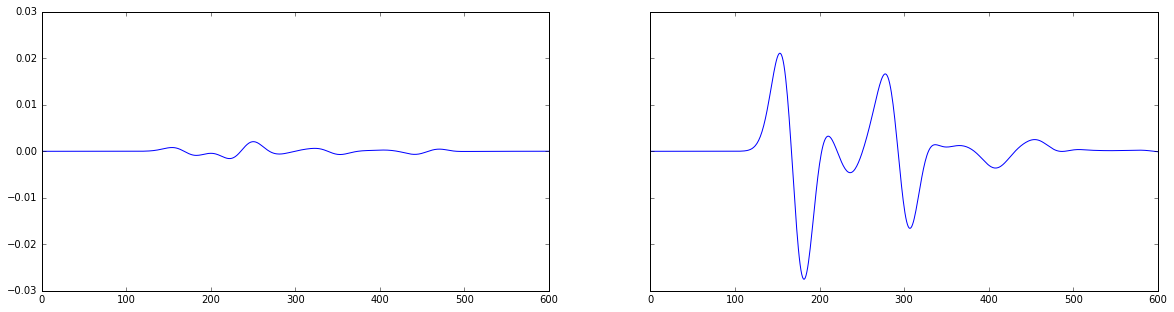

In [3]:
fig, axes = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,5))
with pyasdf.ASDFDataSet("force_verticale.h5") as dataset:
    axes[0].plot(dataset.waveforms.XX_REC1.displacement.select(component='X')[0].data)
    axes[1].plot(dataset.waveforms.XX_REC1.displacement.select(component='Y')[0].data)

We can also easily loop through all 5 seismograms in that file and plot them. There's a simple function to do this below. We'll re-use it later on to compare our own solutions.

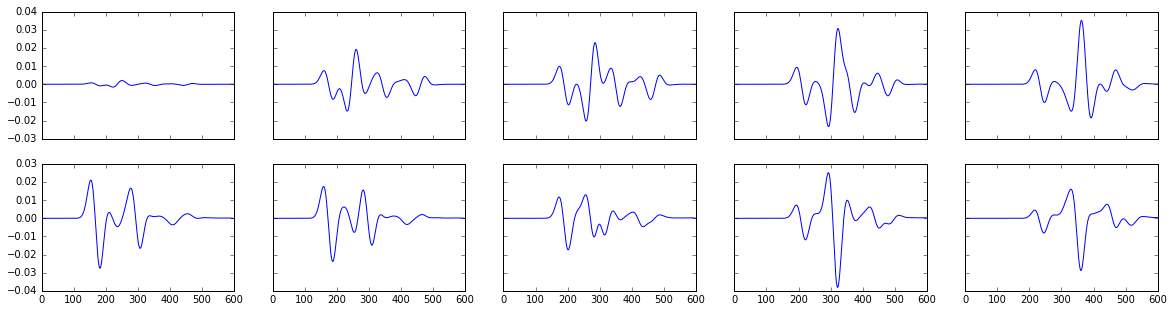

In [4]:
def plot_hdf5_seismograms(asdf_file, axes):
    par_map = ['X', 'Y']
    for i, waveform in enumerate(asdf_file.waveforms):
        for j in range(len(par_map)):
            axes[j,i].plot(waveform.displacement.select(component=par_map[j])[0].data)

fig, axes = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(20, 5))
with pyasdf.ASDFDataSet("force_verticale.h5") as dataset:
    plot_hdf5_seismograms(dataset, axes)

### Running the solver

Now let's get to the fun stuff -- actually running some simulations. We could give it a try immediately, and just run salvus from the command line...

In [5]:
!$SALVUS_BIN $1


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Critical option --mesh-file not set. Exiting.


...but of course that won't work, as we haven't passed any parameters yet. There are a rich variety of parameters and options that Salvus can use, and we'll get to most of them in the coming days. Our goal here however is to just set up and run a simple simulation -- nothing fancy. Salvus is meant to be user friendly, so it should instruct you on how to fail forward. With that in mind, we'll shortly send you out into the wild after a couple quick hints.

Salvus is currently complaining that it doesn't have a mesh file to work with. Let's point it towards the Lamb's problem mesh we defined above.

In [6]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Critical option --model-file not set. Exiting.


Great, another error message. At least this one is different though -- it's telling us that we also need to provide a model. In the future, we plan to support models with different discretizations, but that's not the case for now. For now we pass the same file which defines the mesh as the model.

In [7]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Critical option --polynomial-order not set. Exiting.


Oh brother, another error. But at least it's different. Here we'll leave you be for a bit -- try and get Salvus running yourself. The error messages should lay the path before you. A quick word of advice: when you get there, you want to simulate for precisely 0.52 seconds.

In [8]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

No source specified. Set sources with either --cmd-line-source or --source-toml.
Initializing problem.
Time step set to: 0.000735822 s.
Begin time loop.
Time loop progress [100%].
Time loop completed in 1.08028 seconds.
Begin post processing.
Problem complete.



### Attaching sources
Now we know how to visualize receivers, and run a simple simulation with a mesh. Of course, something is seriously lacking! We didn't actually attach any external sources to the model... we were just crunching a lot of 0s. The next step is to add some simple seismic sources. For this example we'll proceed with specifying a single source from the command line. Doing so is easy enough, just add `--cmd-line-source` to the arguments above.

In [9]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Must specify --source-temporal-type [ ricker ]


Here we can again follow the path outlined by the error messages. We've specified that we want to attach a source, but we haven't specified what kind of source we'd like. From the options above, we'll choose a Ricker source time function.

In [10]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source \
 --source-temporal-type ricker


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Must specify --source-spatial-type [ scalar, vector, moment_tensor ]


Now, we need to choose the spatial characteristics of our source. Let's choose `scalar` as an initial guess.

In [11]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type scalar


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Must specify --source-location-x.


And here again, we'll leave you to stumble forwards on your own. Remember to keep the dimensions of the domain in mind (you can visually check these in `Paraview`.

In [12]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type scalar \
 --source-location-x 0 \
 --source-location-y 1500 \
 --source-scale 1 \
 --source-center-frequency 14.5


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Source in Elastic element must be either type vector or moment tensor.


There is one catastrophic error left. This is communicated in the line `Source in Elastic element must be either type vector or moment tensor.`. Perhaps you thought it was suspicious earlier when we specified the source as a scalar source -- we're running an elastic simulation! Salvus attempted to attach the scalar source to an elastic element, found that it was unable to, and threw an error. Let's fix that by specifying the correct source type.

In [13]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type vector \
 --source-location-x 0 \
 --source-location-y 1500 \
 --source-scale 1 \
 --source-center-frequency 14.5


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Must specify --source-scale. If specified, check number of components. For scalar, this should be 1, vector n_dim, and moment_tensor n_dim * (n_dim + 1) / 2).
For example: A symmetric moment tensor source in 2 dimensions could be specified by --source-scale 1,1,1 (voigt notation). A vector source in 2 dimensions could be specified by --source-scale 1,1.


Of course now our scaling parameter is incorrect, as we've only passed a scalar value. We need to pass a vector source, with dimensions `n_dim`, as the error message says. Let's pass something with some power: set `--source-scale` to `1e9,1e9`.

In [14]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type vector \
 --source-location-x 0 \
 --source-location-y 1500 \
 --source-scale 1e9,1e9 \
 --source-center-frequency 14.5


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 1.34675 seconds.
Begin post processing.
Problem complete.



Ok, and there we go. It looks like everything has completed successfully, with no complaints. Now we have (apparently) injected some energy and got a meaningful result. Now we just need to see what it is we have done.

### Visualizing the solution
We'll eventually get to measuring the data at receivers, but it is often very useful (and just darn cool) to see a movie of what we're doing. It also allows us to reason about how the choices we've made above affect the simulation results. Fortunately, this is quite easy -- it just requires a few more options. In keeping with our anarchic spirit, we'll give the hint that `--save-movie` must be passed, and let you figure out the rest. As one more hint, the fields that we visualize are named the same as those specified for the receivers above, and vector fields are allowed.

In [15]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type vector \
 --source-location-x 0 \
 --source-location-y 1500 \
 --source-scale 1e9,1e9 \
 --source-center-frequency 14.5 \
 --save-movie \
 --movie-file-name movie.h5 \
 --movie-fields u_ELASTIC


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 2.1329 seconds.
Begin post processing.
Problem complete.



The movie is now created -- if you look in this example directory you should see a `movie.h5`, or whatever you decided to name it (the `.h5` suffix tells us that this, like the receivers, is also an `hdf5` file).

There are actually _two_ ways to make movies in Salvus, and this is the quicker (but lower resolution) way. This method uses the internal machinery of `PETSc` to write out the mesh topology, and save field values at the element vertices. This ignores the high-order accuracy of the spectral element method, and results in a coarser movie -- but I'm getting ahead of myself. We'll see an example of the higher resolution movies in the tutorial on inversion. To turn this file into something that `Paraview` can read, we use a script provided by `PETSc`, called `petsc_gen_xdmf.py`. This script is located in the `bin/` directory of your `PETSc` installation.

In [16]:
!python ./petsc_gen_xdmf.py movie.h5

Let's open it in `Paraview`

In [17]:
!$PARAVIEW_BIN movie.xmf

Failed to load data file:  movie.xmf

Pretty neat. Spend a bit of time playing with the different options we've specified so far, and see how this affects the resulting movie. Try and make the simulation explode -- it shouldn't be too hard. Try setting `--start-time` and `--end-time` to different values, and changing the frequency content of the source, to see how the solution changes.

### Receivers
Of course, we didn't come here to watch pretty movies -- our goal is to recreate that analytical test! We're almost there, we just need to add some receivers. This time, the options will be spelt out for you. You need to add:
```
--number-of-receivers 5
--receiver-names rec1,rec2,rec3,rec4,rec5
--receiver-location-x 10,110,210,310,410
--receiver-location-y 1800,1800,1800,1800,1800
--receiver-file-name receivers.h5
--receiver-fields u_ELASTIC
--receiver-medium solid
```

In [18]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --end-time 0.52 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type vector \
 --source-location-x 0 \
 --source-location-y 1500 \
 --source-scale 1e9,1e9 \
 --source-center-frequency 14.5 \
 --save-movie \
 --movie-file-name movie.h5 \
 --movie-fields u_ELASTIC \
 --number-of-receivers 5 \
 --receiver-names XX.REC1,XX.REC2,XX.REC3,XX.REC4,XX.REC5 \
 --receiver-location-x 10,110,210,310,410 \
 --receiver-location-y 1800,1800,1800,1800,1800 \
 --receiver-file-name receivers.h5 \
 --receiver-fields u_ELASTIC \
 --receiver-medium solid,solid,solid,solid,solid


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.107544.
Time step set to: 0.000735822 s.
Start time set to -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 2.14782 seconds.
Begin post processing.
Problem complete.



Now, there is an `ASDF` file in the currenty directory called `receivers.h5`. This has the same format as the file we've already looked at, so we can just use the same script to look at it again.

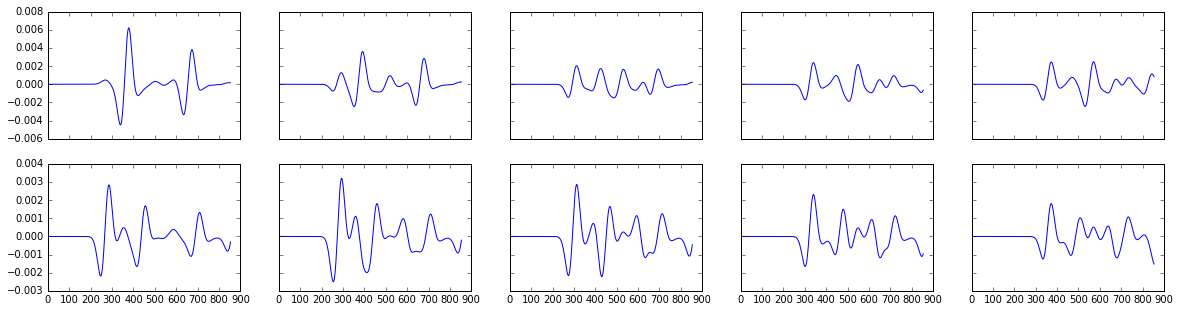

In [19]:
fig, axes = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(20,5))
with pyasdf.ASDFDataSet('receivers.h5') as salvus_rec_file:
    plot_hdf5_seismograms(salvus_rec_file, axes)

Definitely look like seismograms! How do these compare to the analytic ones we're testing against? Just call that function twice, once with the new file handle, and once with the old one.

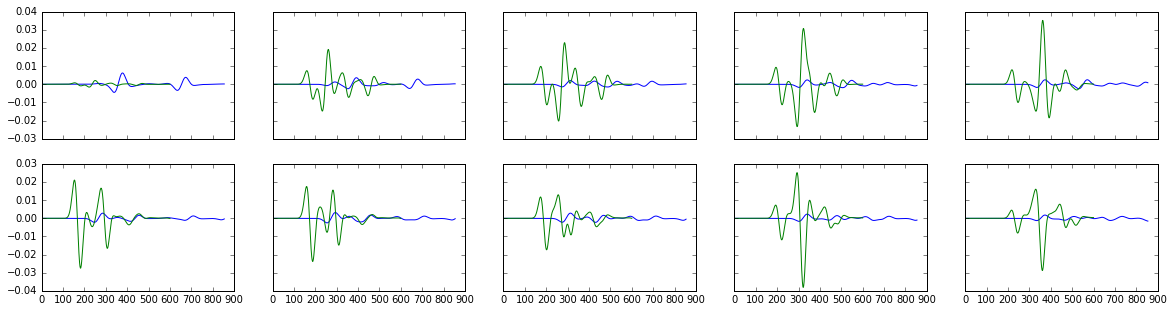

In [20]:
fig, axes = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(20,5))
with pyasdf.ASDFDataSet('receivers.h5') as salvus, \
        pyasdf.ASDFDataSet('force_verticale.h5') as analytic:
    plot_hdf5_seismograms(salvus, axes)
    plot_hdf5_seismograms(analytic, axes)

Hmm, not so ideal. It's up to you now to make them match. Here are the parameters you need.
* Time step: 1e-3
* Start time: -8e-2
* End time: 5.2e-1
* Ricker central frequency: 14.5
* Source location: (0,1500)
* Source direction: (0,-1e10)
Good luck!

In [21]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --start-time -0.08 \
 --end-time 0.52 \
 --time-step 0.001 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type vector \
 --source-location-x 0 \
 --source-location-y 1500 \
 --source-scale 0,-1e10 \
 --source-center-frequency 14.5 \
 --save-movie \
 --movie-file-name movie.h5 \
 --movie-fields u_ELASTIC \
 --number-of-receivers 5 \
 --receiver-names XX.REC1,XX.REC2,XX.REC3,XX.REC4,XX.REC5 \
 --receiver-location-x 10,110,210,310,410 \
 --receiver-location-y 1800,1800,1800,1800,1800 \
 --receiver-file-name receivers.h5 \
 --receiver-fields u_ELASTIC \
 --receiver-medium solid,solid,solid,solid,solid


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Sub-optimal start time detected. This may cause high-frequency artefacts in the simulation. Suggested start time would is -0.107544.
Timestep set by user as: 0.001 s.
Automated timestep would be set to: 0.000735822 s.
Sub-optimal start time detected. This may cause high-frequency artefacts in the simulation. Suggested start time would is -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 1.74899 seconds.
Begin post processing.
Problem complete.



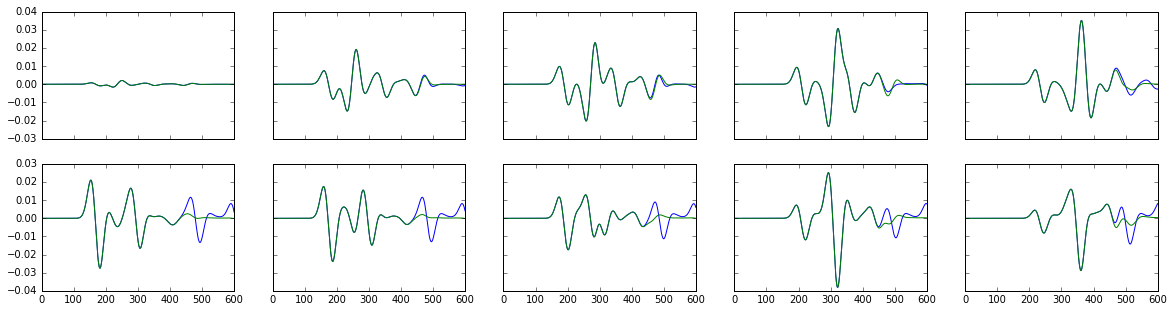

In [22]:
fig, axes = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(20,5))
with pyasdf.ASDFDataSet('receivers.h5') as salvus, \
        pyasdf.ASDFDataSet('force_verticale.h5') as analytic:
    plot_hdf5_seismograms(salvus, axes)
    plot_hdf5_seismograms(analytic, axes)

So close. There is sometimes discrepancies at late times however. These are from the reflections from the mesh edges. It helps to turn on the absorbing boundaries at all edges _except_ the free surface. This is located at the top, labelled by side set `y1`. We can turn on absorbing boundaries on the other edges by specifying `--absorbing-boundaries x0,x1,y0`.

In [23]:
!$SALVUS_BIN \
 --mesh-file $LAMBS_PROBLEM_MESH \
 --model-file $LAMBS_PROBLEM_MESH \
 --polynomial-order 4 \
 --dimension 2 \
 --start-time -0.08 \
 --end-time 0.52 \
 --time-step 0.001 \
 --cmd-line-source \
 --source-temporal-type ricker \
 --source-spatial-type vector \
 --source-location-x 0 \
 --source-location-y 1500 \
 --source-scale 0,-1e10 \
 --source-center-frequency 14.5 \
 --save-movie \
 --movie-file-name movie.h5 \
 --movie-fields u_ELASTIC \
 --number-of-receivers 5 \
 --receiver-names XX.REC1,XX.REC2,XX.REC3,XX.REC4,XX.REC5 \
 --receiver-location-x 10,110,210,310,410 \
 --receiver-location-y 1800,1800,1800,1800,1800 \
 --receiver-file-name receivers.h5 \
 --receiver-fields u_ELASTIC \
 --receiver-medium solid,solid,solid,solid,solid \
 --absorbing-boundaries x0,x1,y0


Salvus version 0.0.1-969-gfe1372d
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Sub-optimal start time detected. This may cause high-frequency artefacts in the simulation. Suggested start time would is -0.107544.
Timestep set by user as: 0.001 s.
Automated timestep would be set to: 0.000735822 s.
Sub-optimal start time detected. This may cause high-frequency artefacts in the simulation. Suggested start time would is -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 2.09284 seconds.
Begin post processing.
Problem complete.



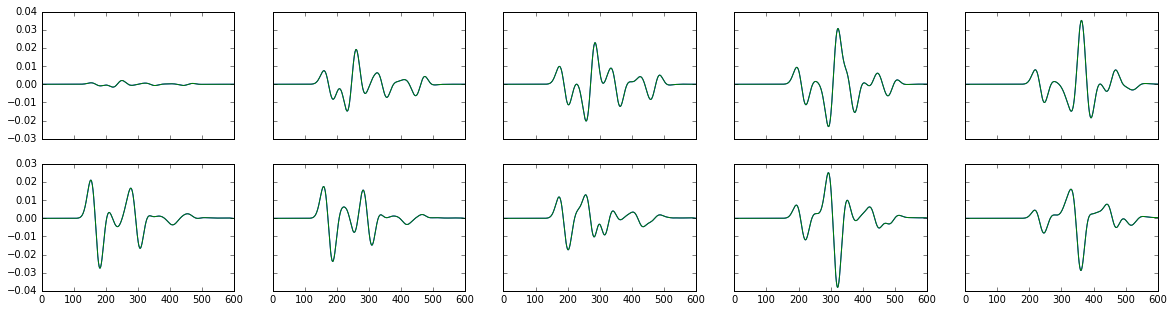

In [24]:
fig, axes = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(20,5))
with pyasdf.ASDFDataSet('receivers.h5') as salvus, \
        pyasdf.ASDFDataSet('force_verticale.h5') as analytic:
    plot_hdf5_seismograms(salvus, axes)
    plot_hdf5_seismograms(analytic, axes)

### Perfect.